(vertical-ref)=

# Vertical referencing

xDEM supports the use of **vertical coordinate reference systems (vertical CRSs)** and vertical transformations for DEMs
by conveniently wrapping PROJ pipelines through [Pyproj](https://pyproj4.github.io/pyproj/stable/) in the {class}`~xdem.DEM` class.

```{important}
**A {class}`~xdem.DEM` already possesses a {class}`~xdem.DEM.crs` attribute that defines its 2- or 3D CRS**, inherited from
{class}`~geoutils.Raster`. Unfortunately, most DEM products do not yet come with a 3D CRS in their raster metadata, and
vertical CRSs often have to be set by the user. See {ref}`vref-setting` below.
```

## What is a vertical CRS?

A vertical CRS is a **1D, often gravity-related, coordinate reference system of surface elevation** (or height), used to expand a [2D CRS](https://en.wikipedia.org/wiki/Spatial_reference_system) to a 3D CRS.

There are two types of 3D CRSs, related to two types of definition of the vertical axis:
- **Ellipsoidal heights** CRSs, that are simply 2D CRS promoted to 3D by explicitly adding an elevation axis to the ellipsoid used by the 2D CRS,
- **Geoid heights** CRSs, that are a compound of a 2D CRS and a vertical CRS (2D + 1D), where the vertical CRS of the geoid is added relative to the ellipsoid.

In xDEM, we merge these into a single vertical CRS attribute {class}`DEM.vcrs<xdem.DEM.vcrs>` that takes two types of values:
- the string `"Ellipsoid"` for any ellipsoidal CRS promoted to 3D (e.g., the WGS84 ellipsoid), or
- a {class}`pyproj.CRS<pyproj.crs.CRS>` with only a vertical axis for a CRS based on geoid heights (e.g., the EGM96 geoid).

In practice, a {class}`pyproj.CRS<pyproj.crs.CRS>` with only a vertical axis is either a {class}`~pyproj.crs.BoundCRS` (when created from a grid) or a {class}`~pyproj.crs.VerticalCRS` (when created in any other manner).

## Methods to manipulate vertical CRSs

The parsing, setting and transformation of vertical CRSs revolves around **three methods**, all described in details further below:
- The **instantiation** of {class}`~xdem.DEM` that implicitly tries to set the vertical CRS from the metadata (or explicitly through the `vcrs` argument),
- The **setting** method {func}`~xdem.DEM.set_vcrs` to explicitly set the vertical CRS of a {class}`~xdem.DEM`,
- The **transformation** method {func}`~xdem.DEM.to_vcrs` to explicitly transform the vertical CRS of a {class}`~xdem.DEM`.

```{caution}
As of now, **[Rasterio](https://rasterio.readthedocs.io/en/stable/) does not support vertical transformations during CRS reprojection** (even if the CRS
provided contains a vertical axis).
We therefore advise to perform horizontal transformation and vertical transformation independently using {func}`DEM.reproject<xdem.DEM.reproject>` and {func}`DEM.to_vcrs<xdem.DEM.to_vcrs>`, respectively.
```

(vref-setting)=
## Automated vertical CRS detection

During instantiation of a {class}`~xdem.DEM`, the vertical CRS {attr}`~xdem.DEM.vcrs` is tentatively set with the following priority order:

1. **From the {attr}`~xdem.DEM.crs` of the DEM**, if 3-dimensional,

In [1]:
import xdem

# Replace this with a new DEM in xdem-data
import numpy as np
import pyproj
import rasterio as rio
dem = xdem.DEM.from_array(data=np.ones((2,2)),
                     transform=rio.transform.from_bounds(0, 0, 1, 1, 2, 2),
                     crs=pyproj.CRS("EPSG:4326+5773"),
                     nodata=None)
dem.save("mydem_with3dcrs.tif")

ERROR 1: PROJ: proj_create_from_database: Open of /home/docs/checkouts/readthedocs.org/user_builds/xdem/conda/latest/share/proj failed


In [2]:
import xdem

# Open a DEM with a 3D CRS
dem = xdem.DEM("mydem_with3dcrs.tif")
# First, let's look at what was the 3D CRS
pyproj.CRS(dem.crs)

<Compound CRS: EPSG:9707>
Name: WGS 84 + EGM96 height
Axis Info [ellipsoidal|vertical]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
- [up]: Gravity-related height (metre)
Area of Use:
- undefined
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich
Sub CRS:
- WGS 84
- EGM96 height

In [3]:
# The vertical CRS is extracted automatically
dem.vcrs

<Vertical CRS: EPSG:5773>
Name: EGM96 height
Axis Info [vertical]:
- [up]: Gravity-related height (metre)
Area of Use:
- undefined
Datum: EGM96 geoid
- Ellipsoid: undefined
- Prime Meridian: undefined

In [4]:
import os
os.remove("mydem_with3dcrs.tif")

2. **From the {attr}`~xdem.DEM.product` name of the DEM**, if parsed from the filename by {class}`geoutils.SatelliteImage`.


```{see-also}
The {class}`~geoutils.SatelliteImage` parent class that parses the product metadata is described in [a dedicated section of GeoUtils' documentation](https://geoutils.readthedocs.io/en/latest/satimg_class.html).
```

In [5]:
# Replace this with a new DEM in xdem-data
import rasterio as rio
dem = xdem.DEM.from_array(data=np.ones((2,2)),
                     transform=rio.transform.from_bounds(0, 0, 1, 1, 2, 2),
                     crs=pyproj.CRS("EPSG:4326"),
                     nodata=None)
# Save with the name of an ArcticDEM strip file
dem.save("SETSM_WV03_20151101_104001001327F500_104001001312DE00_seg2_2m_v3.0_dem.tif")

In [6]:
# Open an ArcticDEM strip file, recognized as an ArcticDEM product by SatelliteImage
dem = xdem.DEM("SETSM_WV03_20151101_104001001327F500_104001001312DE00_seg2_2m_v3.0_dem.tif")
# The vertical CRS is set as "Ellipsoid" from knowing that is it an ArcticDEM product
dem.vcrs

'Ellipsoid'

In [7]:
os.remove("SETSM_WV03_20151101_104001001327F500_104001001312DE00_seg2_2m_v3.0_dem.tif")

**Currently recognized DEM products**:

```{list-table}
   :widths: 1 1
   :header-rows: 1

   * - **DEM**
     - **Vertical CRS**
   * - [ArcticDEM](https://www.pgc.umn.edu/data/arcticdem/)
     - Ellipsoid
   * - [REMA](https://www.pgc.umn.edu/data/arcticdem/)
     - Ellipsoid
   * - [EarthDEM](https://www.pgc.umn.edu/data/earthdem/)
     - Ellipsoid
   * - [TanDEM-X global DEM](https://geoservice.dlr.de/web/dataguide/tdm90/)
     - Ellipsoid
   * - [NASADEM-HGTS](https://lpdaac.usgs.gov/documents/592/NASADEM_User_Guide_V1.pdf)
     - Ellipsoid
   * - [NASADEM-HGT](https://lpdaac.usgs.gov/documents/592/NASADEM_User_Guide_V1.pdf)
     - EGM96
   * - [ALOS World 3D](https://www.eorc.jaxa.jp/ALOS/en/aw3d30/aw3d30v11_format_e.pdf)
     - EGM96
   * - [SRTM v4.1](http://www.cgiar-csi.org/data/srtm-90m-digital-elevation-database-v4-1)
     - EGM96
   * - [ASTER GDEM v2-3](https://lpdaac.usgs.gov/documents/434/ASTGTM_User_Guide_V3.pdf)
     - EGM96
   * - [Copernicus DEM](https://spacedata.copernicus.eu/web/cscda/dataset-details?articleId=394198)
     - EGM08
```

If your DEM does not have a `.vcrs` after instantiation, none of those steps worked. You can define the vertical CRS
explicitly during {class}`~xdem.DEM` instantiation with the `vcrs` argument or with {func}`~xdem.DEM.set_vcrs`,
with user inputs described below.

## Setting a vertical CRS with convenient user inputs

The vertical CRS of a {class}`~xdem.DEM` can be set or re-set manually at any point using {func}`~xdem.DEM.set_vcrs`.

The `vcrs` argument, consistent across the three functions {class}`~xdem.DEM`, {func}`~xdem.DEM.set_vcrs` and {func}`~xdem.DEM.to_vcrs`,
accepts a **wide variety of user inputs**:

- **Simple strings for the three most common references: `"Ellipsoid"`, `"EGM08"` or `"EGM96"`**,

In [8]:
# Set a geoid vertical CRS based on a string
dem.set_vcrs("EGM96")
dem.vcrs

<Vertical CRS: EPSG:5773>
Name: EGM96 height
Axis Info [vertical]:
- H[up]: Gravity-related height (metre)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: EGM96 geoid
- Ellipsoid: undefined
- Prime Meridian: undefined

In [9]:
# Set a vertical CRS extended from the ellipsoid of the DEM's CRS
dem.set_vcrs("Ellipsoid")
dem.vcrs

'Ellipsoid'

- **Any PROJ grid name available at [https://cdn.proj.org/](https://cdn.proj.org/)**,

```{tip}
**No need to download the grid!** This is done automatically during the setting operation, if the grid does not already exist locally.
```

In [10]:
# Set a geoid vertical CRS based on a grid
dem.set_vcrs("us_noaa_geoid06_ak.tif")
dem.vcrs

/home/docs/checkouts/readthedocs.org/user_builds/xdem/checkouts/latest/xdem/vcrs.py:120: UserWarning: Grid not found in /home/docs/checkouts/readthedocs.org/user_builds/xdem/conda/latest/share/proj. Attempting to download from https://cdn.proj.org/...
  warnings.warn(


<Bound CRS: {"$schema": "https://proj.org/schemas/v0.2/projjso ...>
Name: unknown using geoidgrids=us_noaa_geoid06_ak.tif
Axis Info [vertical]:
- H[up]: Gravity-related height (metre)
Area of Use:
- undefined
Coordinate Operation:
- name: unknown to WGS84 ellipsoidal height
- method: GravityRelatedHeight to Geographic3D
Datum: None
- Ellipsoid: undefined
- Prime Meridian: undefined
Source CRS: unknown using geoidgrids=us_noaa_geoid06_ak.tif

- **Any EPSG code as {class}`int`**,

In [11]:
# Set a geoid vertical CRS based on an EPSG code
dem.set_vcrs(5773)
dem.vcrs

<Vertical CRS: EPSG:5773>
Name: EGM96 height
Axis Info [vertical]:
- H[up]: Gravity-related height (metre)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: EGM96 geoid
- Ellipsoid: undefined
- Prime Meridian: undefined

- **Any {class}`~pyproj.crs.CRS` that possesses a vertical axis**.

In [12]:
# Set a vertical CRS based on a pyproj.CRS
import pyproj
dem.set_vcrs(pyproj.CRS("EPSG:3855"))
dem.vcrs

<Vertical CRS: EPSG:3855>
Name: EGM2008 height
Axis Info [vertical]:
- H[up]: Gravity-related height (metre)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: EGM2008 geoid
- Ellipsoid: undefined
- Prime Meridian: undefined

## Transforming to another vertical CRS

To transform a {class}`~xdem.DEM` to a different vertical CRS, {func}`~xdem.DEM.to_vcrs` is used.

```{note}
If your transformation requires a grid that is not available locally, it will be **downloaded automatically**.
xDEM uses only the best available (i.e. best accuracy) transformation returned by {class}`pyproj.transformer.TransformerGroup`, considering the area-of-interest as the DEM extent {class}`~xdem.DEM.bounds`.
```

In [13]:
# Open a DEM and set its CRS
filename_dem = xdem.examples.get_path("longyearbyen_ref_dem")
dem = xdem.DEM(filename_dem, vcrs="Ellipsoid")
trans_dem = dem.to_vcrs("EGM96")
trans_dem.vcrs

<Vertical CRS: EPSG:5773>
Name: EGM96 height
Axis Info [vertical]:
- H[up]: Gravity-related height (metre)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: EGM96 geoid
- Ellipsoid: undefined
- Prime Meridian: undefined

The operation returns a new {class}`~xdem.DEM` by default, but can also be done in-place. It vertically shifts
each pixel value by the transformation at their coordinates:

In [14]:
import numpy as np

diff = trans_dem - dem
# Mean difference after transformation (about 30 m in Svalbard)
np.nanmean(diff)

-32.087208

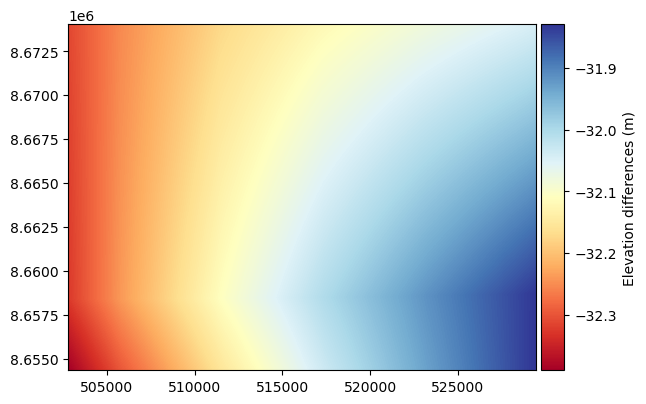

In [15]:
# Plot the elevation differences due to the vertical transformation
diff.plot(cmap="RdYlBu", cbar_title="Elevation differences (m)")